# Density-adjusted group connection test

In [1]:

import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.simulations import sbm
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import FIG_PATH, OUT_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.perturb import remove_edges
from pkg.plot import (
    SmartSVG,
    draw_hypothesis_box,
    heatmap_grouped,
    networkplot_simple,
    plot_pvalues,
    set_theme,
)
from pkg.stats import compute_density, stochastic_block_test
from svgutils.compose import Figure, Panel, Text
from tqdm import tqdm

DISPLAY_FIGS = False

FILENAME = "adjusted_sbm_unmatched_test"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [2]:

set_theme()
np.random.seed(888888)
ns = [5, 6, 7]
B = np.array([[0.8, 0.2, 0.05], [0.05, 0.9, 0.2], [0.05, 0.05, 0.7]])
A1, labels = sbm(ns, B, directed=True, loops=False, return_labels=True)

node_data = pd.DataFrame(index=np.arange(A1.shape[0]))
node_data["labels"] = labels + 1
palette = dict(zip(np.unique(labels) + 1, sns.color_palette("Set2")[3:]))


fig, axs = plt.subplots(
    2,
    2,
    figsize=(6, 5),
    # constrained_layout=True,
    gridspec_kw=dict(wspace=0.25, hspace=0, height_ratios=[2, 0.3]),
)


ytop = 1.05
ybottom = 0.11
xleft = 0.05
xright = 0.68
border_color = "lightgrey"
line1 = mpl.lines.Line2D(
    (0.15, 0.95),
    (0.4, 0.4),
    transform=fig.transFigure,
    color=border_color,
    linewidth=1.5,
)

# fig.lines = (line1,)


ax = axs[0, 0]
_, _, misc = stochastic_block_test(A1, A1, node_data["labels"], node_data["labels"])
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(r"$\hat{B}^{(R)}$", color=network_palette["Right"], size="large")
ax.set_title(
    "Scale connection probabilities\nto match densities",
    fontsize="medium",
    x=1.1,
    y=1.3,
)

ax = axs[0, 1]
Bhat1 = misc["probabilities1"].values
top_ax, left_ax = heatmap_grouped(0.6 * Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title(
    r"$\hat{B}^{(R)}$", color=network_palette["Right"], x=0.55, size="large"
)
top_ax.text(0.94, -1.2, r"$c$", size="large")

# ax.autoscale("off")
ax.annotate(
    "",
    xy=(0, 1.5),
    xytext=(-0.9, 1.5),
    arrowprops=dict(
        arrowstyle="simple",
        shrinkA=5,
        shrinkB=10,
        facecolor="black",
    ),
    zorder=1,
    clip_on=False,
)

from giskard.plot import merge_axes

ax = merge_axes(fig, axs, rows=1)
# ax.set_title("Run group\nconnection test", y=1.1, x=0.6, fontsize="small")
ax.axis("off")
ax.set(xlim=(0, 1), ylim=(0, 2))

draw_hypothesis_box("dasbm", 0.27, 2, ax=ax, yskip=1.2, ypad=0.03)

fig.set_facecolor("w")

gluefig("adjusted_methods_explain", fig)

In [3]:

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

node_data = networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)

n_select = 10
row_inds, col_inds = np.nonzero(A1)
np.random.seed(8888)
choice_inds = np.random.choice(len(row_inds), size=n_select)
for i in choice_inds:
    source_node = row_inds[i]
    target_node = col_inds[i]
    x1, y1 = node_data.loc[source_node, ["x", "y"]]
    x2, y2 = node_data.loc[target_node, ["x", "y"]]
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    ax.text(
        x,
        y,
        "x",
        va="center",
        ha="center",
        color="darkred",
        fontsize="medium",
        zorder=2,
    )


ax.set_title("Remove edges to\n match density (random)", fontsize="medium")
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

fig.set_facecolor("white")
gluefig("edge_removal_methods", fig)

In [4]:
n_edges_left = np.count_nonzero(left_adj)
n_edges_right = np.count_nonzero(right_adj)
n_left = left_adj.shape[0]
n_right = right_adj.shape[0]
density_left = n_edges_left / (n_left**2)
density_right = n_edges_right / (n_right**2)

n_remove = int((density_right - density_left) * (n_right**2))

glue("n_remove", n_remove)

In [5]:

rows = []
n_resamples = 500
glue("n_resamples", n_resamples)
RERUN_SIM = False

if RERUN_SIM:
    for i in tqdm(range(n_resamples)):
        subsampled_right_adj = remove_edges(
            right_adj, effect_size=n_remove, random_seed=rng
        )
        stat, pvalue, misc = stochastic_block_test(
            left_adj,
            subsampled_right_adj,
            labels1=left_labels,
            labels2=right_labels,
        )
        rows.append(
            {
                "stat": stat,
                "pvalue": pvalue,
                "misc": misc,
                "resample": i,
            }
        )
    resample_results = pd.DataFrame(rows)
    resample_results.to_csv(OUT_PATH / "resample_results.csv")
else:
    resample_results = pd.read_csv(OUT_PATH / "resample_results.csv", index_col=0)

In [6]:

left_density = compute_density(left_adj)
right_density = compute_density(right_adj)
c = left_density / right_density
glue("c", c, form="0.2f")

stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
    method="fisher",
    density_adjustment=True,
)
glue("pvalue", pvalue, form="pvalue")

In [7]:
left_nodes["inds"] = np.arange(len(left_nodes))
right_nodes["inds"] = np.arange(len(right_nodes))
left_kc_inds = left_nodes.query("simple_group == 'KCs'")["inds"]
right_kc_inds = right_nodes.query("simple_group == 'KCs'")["inds"]
left_cn_inds = left_nodes.query("simple_group == 'CNs'")["inds"]
right_cn_inds = right_nodes.query("simple_group == 'CNs'")["inds"]

left_kc_cn_adj = left_adj[left_kc_inds][:, left_cn_inds]
right_kc_cn_adj = right_adj[right_kc_inds][:, right_cn_inds]

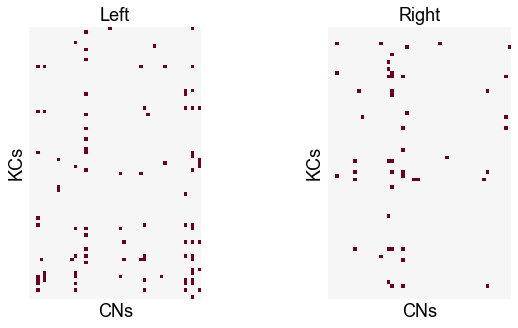

In [8]:
from graspologic.plot import heatmap

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
heatmap_kws = dict(
    xticklabels=False, yticklabels=False, cbar=False, cmap="RdBu_r", center=0, square=True
)
ax.set_title("Left")
sns.heatmap(left_kc_cn_adj, ax=ax, **heatmap_kws)
ax = axs[1]
ax.set_title("Right")
sns.heatmap(right_kc_cn_adj, ax=ax, **heatmap_kws)

for ax in axs.flat: 
    ax.set(xlabel='CNs', ylabel='KCs')

fig.set_facecolor('w')

In [9]:
right_has_kc = right_kc_cn_adj.sum(axis=0) > 0

cn_right_nodes = right_nodes.query("simple_group == 'CNs'").copy()
cn_right_nodes["has_kc"] = right_has_kc
cn_right_nodes.query("has_kc")

,name,neurons,paper_clustered_neurons,left,right,center,sink,partially_differentiated,unsplittable,ipsilateral_axon,...,pair,pair_id,lineage,axon_output,axon_input,dendrite_output,dendrite_input,_inds,inds,has_kc
17019327,CF ; pDM_right,True,True,False,True,False,False,False,False,False,...,11409587,508,DPMpm1_r,327.0,77.0,6.0,181.0,1555,51,True
16339645,JI_right,True,True,False,True,False,False,False,False,False,...,16444552,790,DPLc5_r,232.0,82.0,0.0,149.0,1778,274,True
16405545,Tomato Vine_right,True,True,False,True,False,False,False,False,True,...,12789813,589,DPMpm1_r,324.0,28.0,2.0,326.0,1802,298,True
17438424,SLP1_right; CM13 lat 9,True,True,False,True,False,False,False,False,False,...,17639784,975,CM13_lat_r,552.0,70.0,0.0,274.0,1813,309,True
5791548,DALcm d 5; DALcm12 v e 26 right,True,True,False,True,False,False,False,False,True,...,15519213,696,DALcm12-v_r,337.0,24.0,0.0,119.0,1974,470,True
5669107,L ; DALcm12 m lat 4_right,True,True,False,True,False,False,False,False,False,...,14073503,628,DALcm12-m_r,185.0,41.0,70.0,316.0,1984,480,True
4575178,CH ; BAmd1 lineage_right,True,True,False,True,False,False,False,False,True,...,17176911,912,BAmd1_r,195.0,66.0,0.0,126.0,2046,542,True
6611100,H ; DALcm r v ant med_right,True,True,False,True,False,False,False,False,False,...,17276867,920,DALcm12-m_r,291.0,67.0,12.0,418.0,2168,663,True
4411542,T1 ; DALcl12 d 4_right,True,True,False,True,False,False,False,False,True,...,14071613,627,DALcl12-d_r,336.0,43.0,2.0,190.0,2189,684,True
2667061,ASB TODO B1 right 8 Fragment with soma,True,True,False,True,False,False,False,False,True,...,11011058,475,DPMpl12_r,135.0,29.0,0.0,160.0,2289,784,True


In [10]:
right_has_cn = right_kc_cn_adj.sum(axis=1) > 0
kc_right_nodes = right_nodes.query("simple_group == 'KCs'").copy()
kc_right_nodes["has_cn"] = right_has_cn
kc_right_nodes.query("has_cn")

,name,neurons,paper_clustered_neurons,left,right,center,sink,partially_differentiated,unsplittable,ipsilateral_axon,...,pair,pair_id,lineage,axon_output,axon_input,dendrite_output,dendrite_input,_inds,inds,has_cn
5836206,KC28,True,True,False,True,False,False,False,False,False,...,-1,-1,MBNB A,480.0,206.0,14.0,30.0,1964,460,True
5836197,KC27,True,True,False,True,False,False,False,False,True,...,-1,-1,MBNB C,371.0,209.0,42.0,38.0,1965,461,True
5836163,KC25,True,True,False,True,False,False,False,False,True,...,16630264,827,MBNB A,442.0,185.0,23.0,37.0,1967,463,True
5835815,KC23,True,True,False,True,False,False,False,False,True,...,-1,-1,MBNB D,168.0,118.0,34.0,50.0,1969,465,True
5836387,KC29,True,True,False,True,False,False,False,False,True,...,-1,-1,MBNB D,221.0,110.0,24.0,46.0,1977,473,True
4444354,KC17,True,True,False,True,False,False,False,False,True,...,11691603,515,MBNB A,370.0,169.0,27.0,35.0,2052,548,True
4415241,KC16,True,True,False,True,False,False,False,False,True,...,12726582,97,MBNB A,563.0,293.0,0.0,76.0,2053,549,True
5051342,KC21,True,True,False,True,False,False,False,False,True,...,8262302,272,MBNB A,438.0,160.0,28.0,54.0,2086,582,True
5019924,KC20,True,True,False,True,False,False,False,False,True,...,-1,-1,MBNB A,421.0,185.0,25.0,32.0,2089,585,True
7828725,KC35,True,True,False,True,False,False,False,False,True,...,-1,-1,MBNB A,218.0,106.0,22.0,56.0,2115,611,True


In [11]:

set_theme(font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=resample_results,
    x="pvalue",
    ax=ax,
    color=neutral_color,
    kde=True,
    log_scale=True,
    stat="density",
)
ax.set(xlabel="p-value", ylabel="", yticks=[])
ax.spines["left"].set_visible(False)
ax.axvline(0.05, linestyle=":", color="black")
ylim = ax.get_ylim()
ax.text(0.06, ylim[1] * 0.9, r"$\alpha = 0.05$")

median_resample_pvalue = np.median(resample_results["pvalue"])

colors = sns.color_palette("Set2")


color = colors[2]
ax.axvline(median_resample_pvalue, color=color, linewidth=3)

ax.text(
    median_resample_pvalue - 0.0025,
    ylim[1] * 0.9,
    f"Median = {median_resample_pvalue:0.2g}",
    color=color,
    ha="right",
)

color = "darkred"
ax.axvline(pvalue, 0, 0.58, color=color, linewidth=3, linestyle="--")
ax.text(
    pvalue - 0.0002,
    ylim[1] * 0.48,
    f"Analytic = {pvalue:0.2g}",
    ha="right",
    color=color,
)

gluefig("resampled_pvalues_distribution", fig)

In [12]:

fig, axs = plot_pvalues(misc)

gluefig("sbm_pvalues", fig)

fig, axs = plot_pvalues(misc, annot_missing=False)

gluefig("sbm_pvalues_unlabeled", fig)

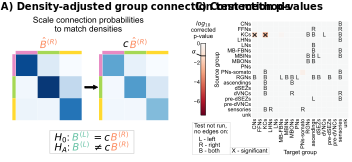

In [13]:


fontsize = 10

methods = SmartSVG(FIG_PATH / "adjusted_methods_explain.svg")
methods.set_width(200)
methods.move(10, 15)
methods_panel = Panel(
    methods,
    Text(
        "A) Density-adjusted group connection test methods",
        0,
        10,
        size=fontsize,
        weight="bold",
    ),
)


pvalues = SmartSVG(FIG_PATH / "sbm_pvalues.svg")
pvalues.set_width(200)
pvalues.move(0, 20)
pvalues_panel = Panel(
    pvalues,
    Text("C) Connection p-values", 5, 10, size=fontsize, weight="bold"),
)
pvalues_panel.move(methods.width * 0.95, 0)

fig = Figure(
    (methods.width + pvalues.width) * 0.88,
    (pvalues.height) * 0.95,
    methods_panel,
    pvalues_panel,
)
fig.save(FIG_PATH / "adjusted_sbm_composite.svg")
fig

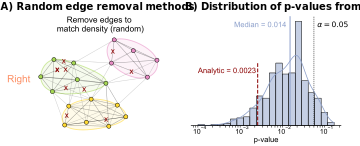

In [14]:
methods = SmartSVG(FIG_PATH / "edge_removal_methods.svg")
methods.set_width(200)
methods.move(5, 15)
methods_panel = Panel(
    methods,
    Text(
        "A) Random edge removal methods",
        0,
        10,
        size=fontsize,
        weight="bold",
    ),
)

distribution = SmartSVG(FIG_PATH / "resampled_pvalues_distribution.svg")
distribution.set_width(200)
distribution.move(10, 15)
distribution_panel = Panel(
    distribution,
    Text(
        "B) Distribution of p-values from subsamples",
        5,
        10,
        size=fontsize,
        weight="bold",
    ),
)
distribution_panel.move(methods.width * 0.9, 0)

fig = Figure(
    (methods.width + distribution.width) * 0.9,
    (distribution.height) * 0.9,
    methods_panel,
    distribution_panel,
)
fig.save(FIG_PATH / "adjusted_sbm_random_composite.svg")
fig

In [15]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:12.619928
Completed at 2022-09-14 09:44:56.674820
